# Using SPICE kernels to study HERA trajectory
In this tutorial we will use the spice kernels available for download at ftp://spiftp.esac.esa.int/data/SPICE/ to study the interplanetary trajectory of the HERA mission


In [1]:
# We need to import some toolboxes 
import pykep as pk
from matplotlib import pyplot as plt
import numpy as np
%matplotlib notebook

## Loading the SPICE kernels

In [2]:
# Assuming the kernels have been downloaded and
# placed in the same directory of this notebook
# 1 - We load the solar system ephemerides
pk.util.load_spice_kernel("de432s.bsp")
# 2 - We load the ephemerides for HERA trajectory
pk.util.load_spice_kernel("HERA_sc_LPC_EMA_2024c.bsp")
# 3 - We load the ephemerides for the Didymos position
pk.util.load_spice_kernel("didymos_hor_200101_300101_v01.bsp")

## A simple use

In [3]:
# We now need to define an epoch (date) to query for positions of the various bodies
# Keep in mind that the kernels do not contain the information for all epochs, only for some
# ranges. You will get an error if you query outside of these bounds
ep = pk.epoch_from_string("2026-Jan-04 12:00:00")
print(ep)

2026-Jan-04 12:00:00


In [4]:
# The code assigned to HERA seems to be -999, so we stick to it. Here we create a fake "planet"
# describing the position of HERA w.r.t. the SUN in the J2000 ecliptic frame and no aberration.
# (ignore the parameters 100 .. 100 and 100 they describe [in pykep syntax] the mass, dimensions and safe
# distance of planets which in this case makes no sense)
hera = pk.planet.spice('-999', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, 100, 100, 100) 

In [5]:
r, v = hera.eph(ep)
print("Position vector at epoch: ", r)
print("Velocity vector at epoch: ", v)

Position vector at epoch:  (-270759976042.35202, -224408729981.53754, 11161707384.613232)
Velocity vector at epoch:  (10603.550394243548, -10862.635786874001, -424.0057060846829)


In [6]:
# We want also the position with respect to didymos? The code assigned to Didymos seems 
# to be 2065803 (apparently using names is not fashionable). So we define a new fake planet object
hera_wrt_didymos = pk.planet.spice('-999', '2065803', 'ECLIPJ2000', 'NONE', pk.MU_SUN, 100, 100, 100) 

In [7]:
r, v = hera_wrt_didymos.eph(ep)
print("Position vector at epoch: ", r)
print("Velocity vector at epoch: ", v)

Position vector at epoch:  (1847403369.0042496, -22574976660.978043, -865934834.397764)
Velocity vector at epoch:  (861.9916442662294, 1239.5955464098067, 342.97888719149586)


In [8]:
# We want also the position with respect to the Earth? We define a new fake planet object
hera_wrt_earth = pk.planet.spice('-999', 'EARTH', 'ECLIPJ2000', 'NONE', pk.MU_SUN, 100, 100, 100) 

In [9]:
r, v = hera_wrt_earth.eph(ep)
print("Position vector at epoch: ", r)
print("Velocity vector at epoch: ", v)

Position vector at epoch:  (-235735253271.4893, -367278379081.661, 11170314994.444817)
Velocity vector at epoch:  (40007.68764017193, -3663.4004080195828, -425.42168268912485)


## Visualizing the whole trajectory

In [10]:
# The documentation of HERA_sc_LPC_EMA_2024c.bsp kernel reveals that the kernel contains the following data:
#
# HERA_sc_LPC_EMA_2024c.bsp
# Bodies                                    Start of Interval (UTC)         End of Interval (UTC)
# -------                                   -----------------------------   -----------------------------
# -999 HERA w.r.t. 4 MARS BARYCENTER        2025-MAR-17 10:05:00.284        2025-MAR-18 22:29:36.525
# -999 HERA w.r.t. 10 SUN                   2024-OCT-27 11:26:16.873        2025-MAR-17 10:05:00.284
#                                           2025-MAR-18 22:29:36.525        2026-DEC-28 11:58:50.816
# -999 HERA w.r.t. 399 EARTH                2024-OCT-25 11:58:50.817        2024-OCT-27 11:26:16.873
#
# In reality it seems the data starts at 2024-OCT-25 12:00:00. So we use that as launch date (anything before seems
# to be absent in the data)

launch = pk.epoch_from_string("2024-OCT-25 12:00:00")
arrival = pk.epoch_from_string("2026-DEC-28 11:58:50.816")
flyby = pk.epoch_from_string("2025-MAR-17 10:05:00.284")


<IPython.core.display.Javascript object>


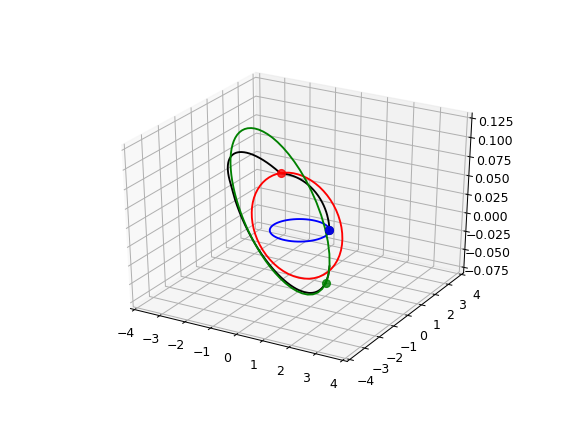

(-4.0, 4.0)

In [11]:
# We reinstantiate the spacecraft orbit for convenience.
hera = pk.planet.spice('-999', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, 100, 100, 100) 
# These are the solar system plants anorbiting objects we are intrerested in
earth = pk.planet.spice('EARTH', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, pk.MU_EARTH, pk.EARTH_RADIUS, pk.EARTH_RADIUS*1.05) 
mars = pk.planet.spice('4', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, 100, 100,100) 
didymos = pk.planet.spice('2065803', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, 100, 100, 100) 

# And these are the plotting commands
ax = pk.orbit_plots.plot_planet(hera, t0 = launch, tf = arrival, N=500, units=pk.AU)
pk.orbit_plots.plot_planet(earth, t0 = launch, axes=ax, color = 'b', units=pk.AU)
pk.orbit_plots.plot_planet(mars, t0 = flyby, axes=ax, color='r', units=pk.AU)
pk.orbit_plots.plot_planet(didymos, t0 = launch, axes=ax, color='g', units=pk.AU)
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)

## Plotting other relevant quantities

In [12]:
# Say we are interested in the HERA-EARTH distance.
tspan = np.linspace(launch.jd, arrival.jd, 100)
Reh = []
Red = []
for jd in tspan:
    r1, _ = hera_wrt_earth.eph(pk.epoch(jd, 'jd'))
    r2, _ = hera_wrt_didymos.eph(pk.epoch(jd, 'jd'))
    Reh.append(np.linalg.norm(r1) / pk.AU)
    Red.append(np.linalg.norm(r2) / pk.AU)



<IPython.core.display.Javascript object>


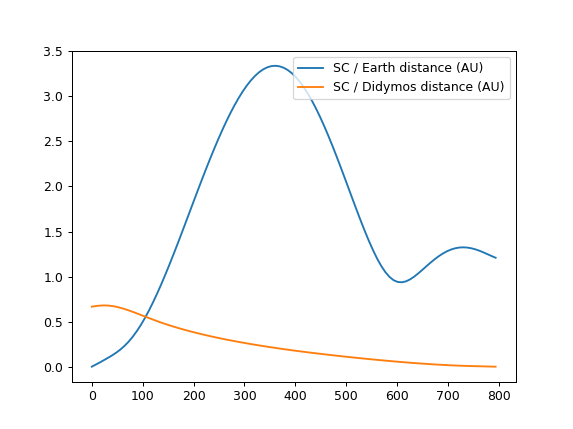

In [13]:
days_from_launch = tspan - launch.jd
plt.figure()
plt.plot(days_from_launch, Reh, label='SC / Earth distance (AU)')
plt.plot(days_from_launch, Red, label='SC / Didymos distance (AU)')
plt.legend()